## Using constraints

This tutorial illustrates how to use RegReg to solve problems using the
container class. We illustrate with an example:

$$
\frac{1}{2}||y - \beta||^{2}_{2} \ \text{subject to} \
||D\beta||_{1} \leq \delta_1, \|\beta\|_1 \leq \delta_2
$$

This problem is solved by solving a dual problem, following the general
derivation in the TFOCS paper

$$
  \frac{1}{2}||y - D^Tu_1 - u_2||^{2}_{2} + \delta_1 \|u_1\|_{\infty}
  + \delta_2 \|u_2\|_{\infty}

For a general loss function, the general objective has the form
$$

$$
  {\cal L}_{\epsilon}(\beta) \ \text{subject to} \ ||D\beta||_{1}
  \leq \delta_1, \|\beta\|_1 \leq \delta_2

which is solved by minimizing the dual
$$

$$
{\cal L}^*_{\epsilon}(-D^Tu_1-u_2) + \delta_1 \|u_1\|_{\infty} +
\delta_2 \|u_2\|_{\infty}
$$

Recall that for the sparse fused LASSO

$$
D = \left(\begin{array}{rrrrrr} -1 & 1 & 0 & 0 & \cdots & 0 \\ 0 &
-1 & 1 & 0 & \cdots & 0 \\ &&&&\cdots &\\ 0 &0&0&\cdots & -1 & 1
\end{array}\right)
$$

To solve this problem using RegReg we begin by loading the necessary
numerical libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import regreg.api as rr
from regreg.affine.fused_lasso import difference_transform

Next, let’s generate an example signal, and solve the Lagrange form of
the problem

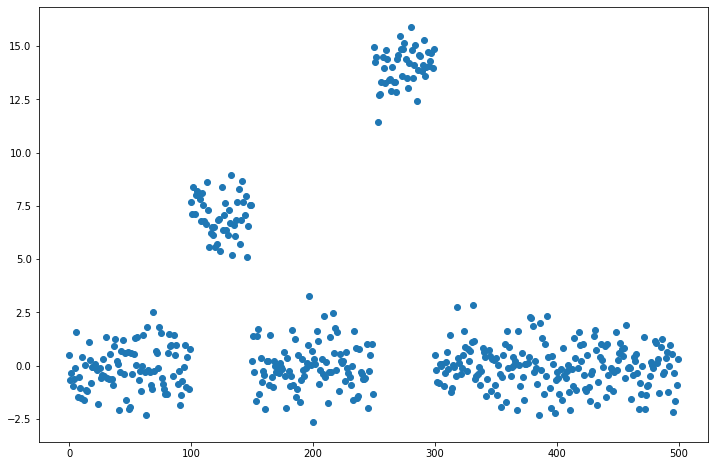

In [3]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
Y = np.random.standard_normal(500); Y[100:150] += 7; Y[250:300] += 14
ax.scatter(np.arange(Y.shape[0]), Y)

In [4]:
loss = rr.signal_approximator(Y)

$$
\frac{C}{2}\left\|\beta - Y_{}\right\|^2_2
$$

In [5]:
sparsity = rr.l1norm(len(Y), lagrange=1.4)
D = difference_transform(np.arange(Y.shape[0]))
fused = rr.l1norm.linear(D, lagrange=15.5)
fused

affine_atom(l1norm((499,), lagrange=15.500000, offset=None), <499x500 sparse matrix of type '<class 'numpy.float64'>'
	with 998 stored elements in Compressed Sparse Row format>)

$$
\lambda_{} \|X_{}\beta\|_1
$$

In [6]:
problem = rr.dual_problem.fromprimal(loss, sparsity, fused)
problem

$$
\begin{aligned} \text{minimize}_{\beta} & f(\beta) + g(\beta) \\
f(\beta) &= \sup_{u \in \mathbb{R}^{p} } \left[ \langle
X_{1}\beta, u \rangle - \left({\cal Z}(u) +
\frac{L_{1}}{2}\|u\|^2_2 + \left \langle \eta_{1}, u \right
\rangle + \gamma_{1} \right) \right] \\ g(\beta) &=
I^{\infty}(\|\beta[g0]\|_{\infty} \leq \delta_{0}) +
I^{\infty}(\|\beta[g1]\|_{\infty} \leq \delta_{1}) \\
\end{aligned}
$$

In [7]:
solution = problem.solve(tol=1.e-14)

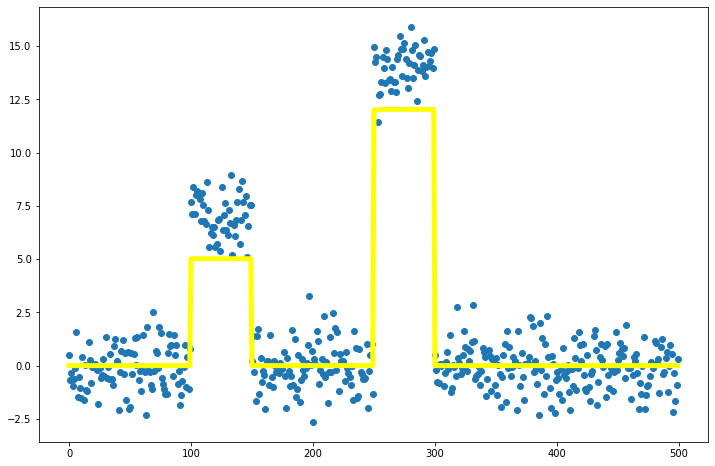

In [8]:
ax.plot(solution, c='yellow', linewidth=5, label='Lagrange')
fig

We will now solve this problem in constraint form, using the achieved
values
$\delta_1 = \|D\widehat{\beta}\|_1, \delta_2=\|\widehat{\beta}\|_1$.
By default, the container class will try to solve this problem with the
two-loop strategy.

In [9]:
delta1 = np.fabs(D * solution).sum()
delta2 = np.fabs(solution).sum()
fused_constraint = rr.l1norm.linear(D, bound=delta1)
sparsity_constraint = rr.l1norm(Y.shape[0], bound=delta2)

In [10]:
constrained_problem = rr.dual_problem.fromprimal(loss,
fused_constraint, sparsity_constraint)
constrained_problem

$$
\begin{aligned} \text{minimize}_{\beta} & f(\beta) + g(\beta) \\
f(\beta) &= \sup_{u \in \mathbb{R}^{p} } \left[ \langle
X_{1}\beta, u \rangle - \left({\cal Z}(u) +
\frac{L_{1}}{2}\|u\|^2_2 + \left \langle \eta_{1}, u \right
\rangle + \gamma_{1} \right) \right] \\ g(\beta) &= \lambda_{0}
\|\beta[g0]\|_{\infty} + \lambda_{1} \|\beta[g1]\|_{\infty} \\
\end{aligned}
$$

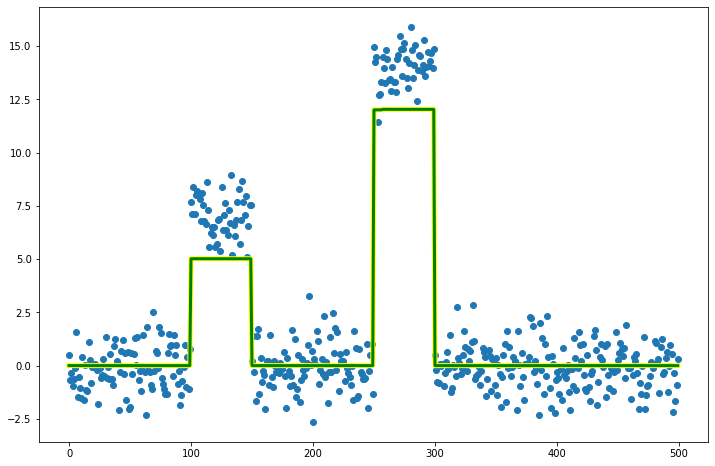

In [11]:
constrained_solution = constrained_problem.solve(tol=1.e-12)
ax.plot(constrained_solution, c='green', linewidth=3, label='Constrained')
fig

## Mixing penalties and constraints

As atoms generally have both bound form and Lagrange form, we can solve
problems with a mix of the two penalties. For instance, we might try
minimizing this objective

$$
\frac{1}{2}||y - \beta||^{2}_{2} + \lambda \|\beta\|_1 \text{
subject to} \ ||D\beta||_{1} \leq \delta.
$$

In [12]:
mixed_problem = rr.dual_problem.fromprimal(loss, fused_constraint, sparsity)
mixed_problem

$$
\begin{aligned} \text{minimize}_{\beta} & f(\beta) + g(\beta) \\
f(\beta) &= \sup_{u \in \mathbb{R}^{p} } \left[ \langle
X_{1}\beta, u \rangle - \left({\cal Z}(u) +
\frac{L_{1}}{2}\|u\|^2_2 + \left \langle \eta_{1}, u \right
\rangle + \gamma_{1} \right) \right] \\ g(\beta) &= \lambda_{0}
\|\beta[g0]\|_{\infty} + I^{\infty}(\|\beta[g1]\|_{\infty} \leq
\delta_{1}) \\ \end{aligned}
$$

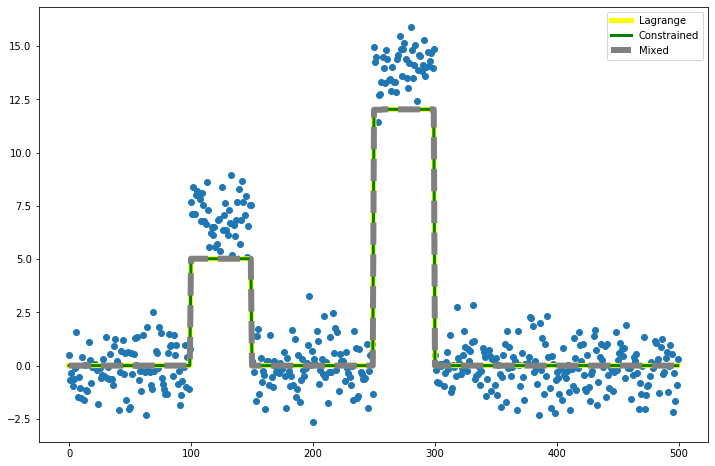

In [13]:
mixed_solution = mixed_problem.solve(tol=1.e-12)
ax.plot(mixed_solution, '--', linewidth=6, c='gray', label='Mixed')
ax.legend()
fig

In [14]:
np.fabs(D * mixed_solution).sum(), fused_constraint.atom.bound
(33.67439163971784, 33.674299924228016)

(33.67439163971784, 33.674299924228016)

# Atoms have affine offsets

Suppose that instead of shrinking the values in the fused LASSO to 0, we
want to shrink them all towards a given vector $\alpha$

This can be achieved, at least conceptually by minimizing

$$
\frac{1}{2}||y - \beta||^{2}_{2} + \lambda_{1}||D\beta||_{1} + \lambda_2 \|\beta-\alpha\|_1
$$

with

Everything is roughly the same as in the fused LASSO, we just need to
change the second seminorm to have this affine offset.

Now we can create the problem object, beginning with the loss function

In [15]:
alpha = np.linspace(0,10,500) - 3
shrink_to_alpha = rr.l1norm(Y.shape, offset=alpha, lagrange=3.)
shrink_to_alpha

l1norm((500,), lagrange=3.000000, offset=array([-3.00000000e+00, -2.97995992e+00, -2.95991984e+00, -2.93987976e+00,
       -2.91983968e+00, -2.89979960e+00, -2.87975952e+00, -2.85971944e+00,
       -2.83967936e+00, -2.81963928e+00, -2.79959920e+00, -2.77955912e+00,
       -2.75951904e+00, -2.73947896e+00, -2.71943888e+00, -2.69939880e+00,
       -2.67935872e+00, -2.65931864e+00, -2.63927856e+00, -2.61923848e+00,
       -2.59919840e+00, -2.57915832e+00, -2.55911824e+00, -2.53907816e+00,
       -2.51903808e+00, -2.49899800e+00, -2.47895792e+00, -2.45891784e+00,
       -2.43887776e+00, -2.41883768e+00, -2.39879760e+00, -2.37875752e+00,
       -2.35871743e+00, -2.33867735e+00, -2.31863727e+00, -2.29859719e+00,
       -2.27855711e+00, -2.25851703e+00, -2.23847695e+00, -2.21843687e+00,
       -2.19839679e+00, -2.17835671e+00, -2.15831663e+00, -2.13827655e+00,
       -2.11823647e+00, -2.09819639e+00, -2.07815631e+00, -2.05811623e+00,
       -2.03807615e+00, -2.01803607e+00, -1.99799599e+00, -

$$
\lambda_{} \|\beta - \alpha_{}\|_1
$$

which creates an affine_atom object with $\lambda_2=3$. That is,
it creates the penalty

$$
3 \|\beta-\alpha\|_{1}
$$

that will be added to a smooth loss function. Next, we create the fused
lasso matrix and the associated l1norm object,

Here we first created D, converted it a sparse matrix, and then created
an l1norm object with the sparse version of D and
$\lambda_1 = 25.5$. Finally, we can create the final problem
object, and solve it.

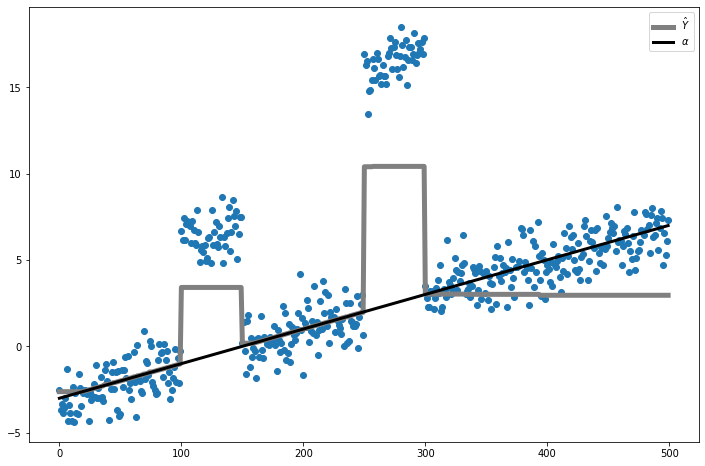

In [16]:
loss_alpha = rr.signal_approximator(Y + alpha)
fig_alpha = plt.figure(figsize=(12,8))
ax_alpha = fig_alpha.gca()
alpha_problem = rr.dual_problem.fromprimal(loss, shrink_to_alpha, fused)
alpha_solution = alpha_problem.solve(tol=1.e-14)
ax_alpha.scatter(np.arange(Y.shape[0]), Y + alpha)
ax_alpha.plot(alpha_solution, c='gray', linewidth=5, label=r'$\hat{Y}$')
ax_alpha.plot(alpha, c='black', linewidth=3, label=r'$\alpha$')
ax_alpha.legend()

We can then plot solution to see the result of the regression,

 Atoms can be smoothed

Atoms can be smoothed using the same smoothing techniques described in
[NESTA](http://statweb.stanford.edu/~candes/nesta/) and
[TFOCS](http://cvxr.com/tfocs/paper/)

Recall that the sparse fused lasso minimizes the objective

$$
\frac{1}{2}||y - \beta||^{2}_{2} + \lambda_{1}||D\beta||_{1} + \lambda_2 \|\beta\|_1
$$

The penalty can be smoothed to create a smooth function object which can
be solved with FISTA.

In [17]:
Q = rr.identity_quadratic(0.1, 0, 0, 0)
smoothed_sparsity = sparsity.smoothed(Q)
smoothed_sparsity

smooth_conjugate(supnorm((500,), bound=1.400000, offset=None, quadratic=identity_quadratic(0.100000, 0.0, 0.0, 0.000000)),identity_quadratic(0.100000, 0.0, 0.0, 0.000000))

$$
\sup_{u \in \mathbb{R}^{p} } \left[ \langle \beta, u \rangle - \left(I^{\infty}(\|u\|_{\infty} \leq \delta_{}) + \frac{L_{}}{2}\|u\|^2_2 \right) \right]
$$

In [18]:
smoothed_fused = fused.smoothed(Q)

In [19]:
problem = rr.smooth_sum([loss, smoothed_sparsity, smoothed_fused])
solver = rr.FISTA(problem)
solver.fit(tol=1.e-10)
smooth_solution = solver.composite.coefs.copy()

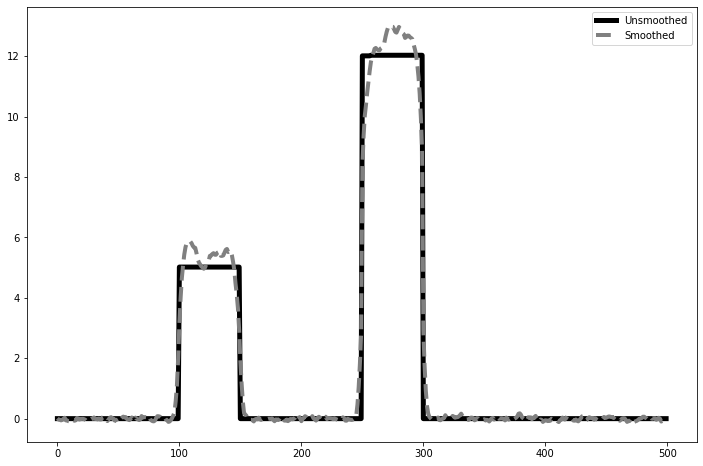

In [20]:
smooth_fig = plt.figure(figsize=(12,8))
smooth_ax = smooth_fig.gca()
smooth_ax.plot(solution, 'k', linewidth=5, label='Unsmoothed')
smooth_ax.plot(smooth_solution, '--', c='gray', linewidth=4, label='Smoothed')
smooth_ax.legend() #doctest: +ELLIPSIS

which has both the loss function and the seminorm represented in it. We
will estimate $\beta$ for various values of $\epsilon$:

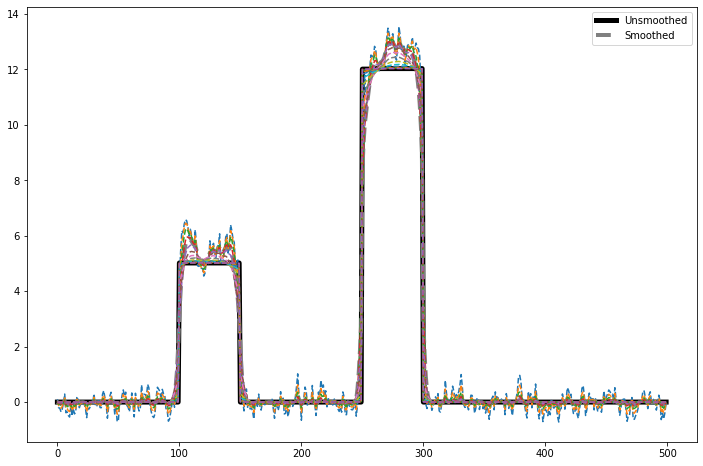

In [21]:
solns = []
for eps in [.5**i for i in range(15)]:
    Q = rr.identity_quadratic(eps, 0, 0, 0)
    smoothed_sparsity = sparsity.smoothed(Q)
    smoothed_fused = fused.smoothed(Q)
    problem = rr.smooth_sum([loss, smoothed_sparsity, smoothed_fused])
    solver = rr.FISTA(problem)
    solver.fit(tol=1.e-10)
    solns.append(solver.composite.coefs.copy())
    smooth_ax.plot(solns[-1], '--')
smooth_fig

Of course, we don’t have to smooth both atoms. We could just smooth the
fused term.

In [22]:
smoothed_fused_constraint = fused_constraint.smoothed(rr.identity_quadratic(1e-3,0,0,0))
smooth_part = rr.smooth_sum([loss, smoothed_fused_constraint])
smoothed_constrained_problem = rr.simple_problem(smooth_part, sparsity_constraint)
smoothed_constrained_solution = smoothed_constrained_problem.solve(tol=1e-12)

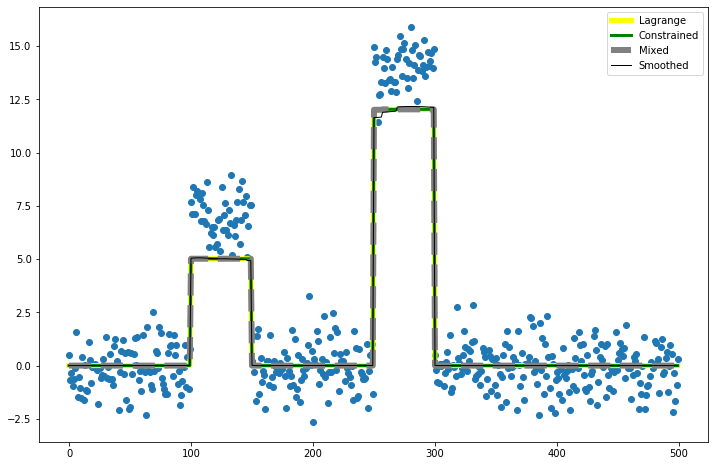

In [23]:
ax.plot(smoothed_constrained_solution, c='black', linewidth=1, label='Smoothed')
ax.legend()
fig